# Berlin bike theft 

possible for parameterization: `date`, `type of theft`, `location`

In [22]:
import os
import pandas as pd

In [50]:
# import data
# !wget -O 2023-03-16_berlin-bike-theft.csv "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
# !wget -O 2023-03-17_berlin-bike-theft.csv "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

# read data

In [92]:
# def custom_date_parser(date_str):
#     return pd.to_datetime(date_str, format='%d.%m.%Y %H')

# bike_theft_df = pd.read_csv(
#     '2023-03-17_berlin-bike-theft.csv',
#     encoding='latin-1',
#     parse_dates={
#         'ANGELEGT_DATUM'   : ['ANGELEGT_AM'],
#         'TATZEIT_ANFANG': ['TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE'], 
#         'TATZEIT_ENDE'  : ['TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE']
#     },
#     date_parser=custom_date_parser)

bike_theft_df = pd.read_csv(
    'data/raw/2023-03-17_berlin-bike-theft.csv',
    encoding='latin-1',
    parse_dates=['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ENDE_DATUM'],
    dayfirst=True)

## explore

In [94]:
bike_theft_df.info()
# bike_theft_df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25876 entries, 0 to 25875
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANGELEGT_AM            25876 non-null  datetime64[ns]
 1   TATZEIT_ANFANG_DATUM   25876 non-null  datetime64[ns]
 2   TATZEIT_ANFANG_STUNDE  25876 non-null  int64         
 3   TATZEIT_ENDE_DATUM     25876 non-null  datetime64[ns]
 4   TATZEIT_ENDE_STUNDE    25876 non-null  int64         
 5   LOR                    25876 non-null  int64         
 6   SCHADENSHOEHE          25876 non-null  int64         
 7   VERSUCH                25876 non-null  object        
 8   ART_DES_FAHRRADS       25876 non-null  object        
 9   DELIKT                 25876 non-null  object        
 10  ERFASSUNGSGRUND        25876 non-null  object        
dtypes: datetime64[ns](3), int64(4), object(4)
memory usage: 2.2+ MB


In [107]:
# get max date as date with format YYYY-MM-DD
date_download = "2023-03-17"
date_last_entry = bike_theft_df['ANGELEGT_AM'].max().date().isoformat()

print(f"Download Date: {date_download}")
print(f"Date Newest Entry: {date_last_entry}")

Download Date: 2023-03-17
Date Newest Entry: 2023-03-15


## transform

In [95]:
# combine TATZEIT_DATUM and TATZEIT_STUNDE to create TATZEIT
bike_theft_df['TATZEIT_ANFANG'] = bike_theft_df['TATZEIT_ANFANG_DATUM'] + pd.to_timedelta(bike_theft_df['TATZEIT_ANFANG_STUNDE'], unit='h')
bike_theft_df['TATZEIT_ENDE'] = bike_theft_df['TATZEIT_ENDE_DATUM'] + pd.to_timedelta(bike_theft_df['TATZEIT_ENDE_STUNDE'], unit='h')

# extract hour from TATZEIT_ANFANG and assign it to TATZEIT_ANFANG_STUNDE
bike_theft_df['TATZEIT_ANFANG_STUNDE'] = bike_theft_df['TATZEIT_ANFANG'].dt.hour
bike_theft_df['TATZEIT_ENDE_STUNDE'] = bike_theft_df['TATZEIT_ENDE'].dt.hour

# generate tatzeit dauer
bike_theft_df['TATZEIT_DAUER'] = (bike_theft_df['TATZEIT_ENDE'] - bike_theft_df['TATZEIT_ANFANG']) / pd.Timedelta(hours=1)


In [88]:
bike_theft_df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATZEIT_ANFANG,TATZEIT_ENDE,TATZEIT_DAUER
0,2023-03-15,2023-03-14,9,2023-03-15,7,3701659,1200,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-14 09:00:00,2023-03-15 07:00:00,22.0
1,2023-03-15,2023-03-14,19,2023-03-15,11,9301126,3399,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-14 19:00:00,2023-03-15 11:00:00,16.0
2,2023-03-15,2023-03-14,8,2023-03-14,21,12400720,699,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-14 08:00:00,2023-03-14 21:00:00,13.0
3,2023-03-15,2023-03-15,18,2023-03-15,18,2500833,2000,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-15 18:00:00,2023-03-15 18:00:00,0.0
4,2023-03-15,2023-03-15,17,2023-03-15,19,1100414,1169,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-15 17:00:00,2023-03-15 19:00:00,2.0


## visualize

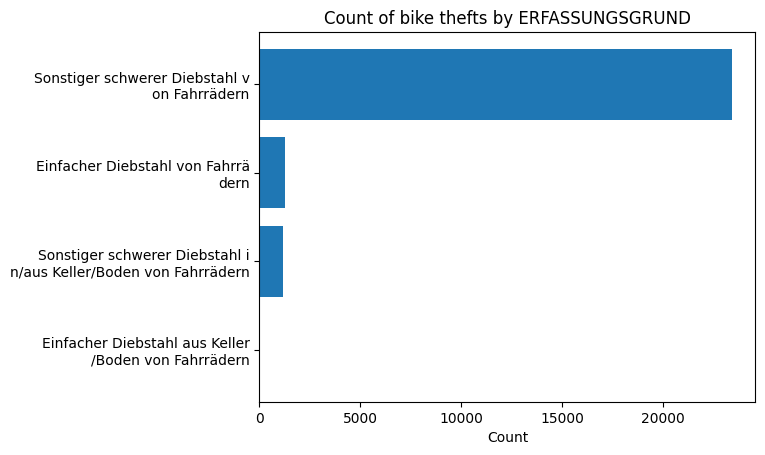

In [89]:
import matplotlib.pyplot as plt

counts = bike_theft_df['ERFASSUNGSGRUND'].value_counts().sort_values(ascending=True)
labels = [f'{s[:30]}\n{s[30:]}' if len(s) > 30 else s for s in counts.index]
plt.barh(labels, counts.values)
plt.xlabel('Count')
plt.title('Count of bike thefts by ERFASSUNGSGRUND')
plt.show()

## export to pq